In [49]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [50]:
# 1. 데이터 경로 설정
base_path = r'D:\my_projects\calmman-facial-classification\data\processed'
teasing_path = os.path.join(base_path, 'teasing')
non_teasing_path = os.path.join(base_path, 'non_teasing')

# 2. 클래스 정의 (이진분류)
classes = ['non_teasing', 'teasing']  # 0: 약올리지 않음, 1: 약올림
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

print(f"클래스 매핑: {class_to_index}")
print(f"약올리기 폴더 존재: {os.path.exists(teasing_path)}")
print(f"비약올리기 폴더 존재: {os.path.exists(non_teasing_path)}")

클래스 매핑: {'non_teasing': 0, 'teasing': 1}
약올리기 폴더 존재: True
비약올리기 폴더 존재: True


In [51]:
import cv2
import numpy as np
from tqdm import tqdm
import os
from PIL import Image

# 3. 데이터 준비 (개선된 버전)
img_size = 224
X = []
y = []

# 이미지 확장자 정의
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

def load_images_from_folder_robust(folder_path, label):
    """강화된 이미지 로딩 함수"""
    images = []
    labels = []
    failed_files = []
    
    if not os.path.exists(folder_path):
        print(f"경고: {folder_path} 폴더가 존재하지 않습니다.")
        return images, labels, failed_files
    
    file_list = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]
    
    for fname in tqdm(file_list, desc=f"Loading {os.path.basename(folder_path)}"):
        img_path = os.path.join(folder_path, fname)
        
        try:
            # 방법 1: OpenCV로 시도
            img = cv2.imread(img_path)
            
            if img is None:
                # 방법 2: PIL로 시도 (한글 경로 문제 해결)
                pil_img = Image.open(img_path)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
            if img is None:
                raise Exception("이미지 로드 실패")
            
            # 이미지 크기 확인
            if img.shape[0] == 0 or img.shape[1] == 0:
                raise Exception("빈 이미지")
            
            # BGR to RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 크기 조정
            img = cv2.resize(img, (img_size, img_size))
            
            # 정규화
            img = img.astype('float32') / 255.0
            
            images.append(img)
            labels.append(label)
            
        except Exception as e:
            failed_files.append(fname)
            print(f"실패: {fname} - {str(e)}")
            continue
    
    return images, labels, failed_files

# 비약올리기 이미지 로드 (라벨: 0)
X_non_teasing, y_non_teasing, failed_non_teasing = load_images_from_folder_robust(non_teasing_path, 0)

# 약올리기 이미지 로드 (라벨: 1)
X_teasing, y_teasing, failed_teasing = load_images_from_folder_robust(teasing_path, 1)

# 데이터 합치기
X = X_non_teasing + X_teasing
y = y_non_teasing + y_teasing

print(f"\n=== 로딩 결과 ===")
print(f"총 이미지 수: {len(X)}")
print(f"비약올리기 이미지: {len(X_non_teasing)}")
print(f"약올리기 이미지: {len(X_teasing)}")
print(f"실패한 비약올리기 파일: {len(failed_non_teasing)}개")
print(f"실패한 약올리기 파일: {len(failed_teasing)}개")

if failed_non_teasing:
    print(f"실패한 비약올리기 파일들: {failed_non_teasing}")
if failed_teasing:
    print(f"실패한 약올리기 파일들: {failed_teasing}")

Loading non_teasing:   0%|          | 0/125 [00:00<?, ?it/s]

Loading teasing: 100%|██████████| 35/35 [00:00<00:00, 1200.57it/s]


=== 로딩 결과 ===
총 이미지 수: 160
비약올리기 이미지: 125
약올리기 이미지: 35
실패한 비약올리기 파일: 0개
실패한 약올리기 파일: 0개


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_minority_class(X_list, y_list, target_ratio=0.8):
    """
    소수 클래스를 다수 클래스의 일정 비율까지 증강
    target_ratio: 다수 클래스 대비 소수 클래스 비율 (0.8 = 80%)
    """
    
    # 클래스별 데이터 분리
    class_0_indices = [i for i, label in enumerate(y_list) if label == 0]
    class_1_indices = [i for i, label in enumerate(y_list) if label == 1]
    
    class_0_data = [X_list[i] for i in class_0_indices]
    class_1_data = [X_list[i] for i in class_1_indices]
    
    print(f"증강 전:")
    print(f"  비약올리기 (클래스 0): {len(class_0_data)}개")
    print(f"  약올리기 (클래스 1): {len(class_1_data)}개")
    print(f"  불균형 비율: {len(class_1_data)/len(class_0_data):.2f}")
    
    # 목표 개수 계산
    target_count = int(len(class_0_data) * target_ratio)
    
    if len(class_1_data) >= target_count:
        print(f"증강 불필요: 이미 목표 비율({target_ratio})을 충족합니다.")
        return X_list, y_list
    
    # 증강기 설정 (약올리기에 적합한 증강)
    datagen = ImageDataGenerator(
        rotation_range=20,           # 회전 (얼굴 각도 변화)
        width_shift_range=0.15,      # 가로 이동
        height_shift_range=0.15,     # 세로 이동
        horizontal_flip=True,        # 좌우 반전
        zoom_range=0.15,             # 확대/축소
        brightness_range=[0.8, 1.2], # 밝기 조정
        fill_mode='nearest'          # 빈 공간 채우기
    )
    
    # 필요한 증강 이미지 개수
    need_count = target_count - len(class_1_data)
    
    print(f"목표 개수: {target_count}개")
    print(f"증강할 이미지: {need_count}개")
    
    augmented_images = []
    augmented_labels = []
    
    # 진행률 표시와 함께 증강
    for i in tqdm(range(need_count), desc="데이터 증강 중"):
        # 기존 약올리기 이미지 중 랜덤 선택
        base_img = class_1_data[i % len(class_1_data)]
        
        # 배치 차원 추가 (ImageDataGenerator 입력 형식)
        img_batch = np.expand_dims(base_img, 0)
        
        # 증강 적용
        aug_iter = datagen.flow(img_batch, batch_size=1)
        aug_img = next(aug_iter)[0]
        
        # 값 범위 확인 및 정규화 유지
        aug_img = np.clip(aug_img, 0.0, 1.0)
        
        augmented_images.append(aug_img)
        augmented_labels.append(1)
    
    # 원본 + 증강 데이터 합치기
    final_X = class_0_data + class_1_data + augmented_images
    final_y = [0] * len(class_0_data) + [1] * len(class_1_data) + augmented_labels
    
    print(f"\n증강 후:")
    print(f"  비약올리기 (클래스 0): {len(class_0_data)}개")
    print(f"  약올리기 (클래스 1): {len(class_1_data) + len(augmented_images)}개")
    print(f"  총 이미지 수: {len(final_X)}개")
    print(f"  최종 비율: {(len(class_1_data) + len(augmented_images))/len(class_0_data):.2f}")
    
    return final_X, final_y

# 데이터 증강 실행
X, y = augment_minority_class(X, y, target_ratio=0.8)

증강 전:
  비약올리기 (클래스 0): 125개
  약올리기 (클래스 1): 35개
  불균형 비율: 0.28
목표 개수: 100개
증강할 이미지: 65개


데이터 증강 중: 100%|██████████| 65/65 [00:00<00:00, 275.23it/s]


증강 후:
  비약올리기 (클래스 0): 125개
  약올리기 (클래스 1): 100개
  총 이미지 수: 225개
  최종 비율: 0.80


In [53]:
# 4. NumPy 배열 변환
X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"클래스 분포: {np.bincount(y)}")

# 5. 학습/검증 데이터 분할 (계층적 샘플링)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"훈련 데이터: {X_train.shape}, 레이블: {y_train.shape}")
print(f"검증 데이터: {X_val.shape}, 레이블: {y_val.shape}")
print(f"훈련 클래스 분포: {np.bincount(y_train)}")
print(f"검증 클래스 분포: {np.bincount(y_val)}")

X shape: (225, 224, 224, 3)
y shape: (225,)
클래스 분포: [125 100]
훈련 데이터: (180, 224, 224, 3), 레이블: (180,)
검증 데이터: (45, 224, 224, 3), 레이블: (45,)
훈련 클래스 분포: [100  80]
검증 클래스 분포: [25 20]


In [27]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# # EfficientNetB0 백본 로드 (ImageNet 사전학습 사용)
# base_model = EfficientNetB0(
#     include_top=False, 
#     weights='imagenet', 
#     input_shape=(224, 224, 3)
# )

# # 특징 추출층
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.3)(x)

# # 이진분류를 위한 출력층
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(1, activation='sigmoid', name='teasing_output')(x)

# # 모델 정의
# model = Model(inputs=base_model.input, outputs=output)

# print("모델이 성공적으로 생성되었습니다.")

In [55]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# EfficientNetB0 백본 로드 및 동결
base_model = EfficientNetB0(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# 백본 동결 (가중치 업데이트 안함)
base_model.trainable = False

# 분류기 헤드만 추가
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

print("모델이 성공적으로 생성되었습니다.")

모델이 성공적으로 생성되었습니다.


In [26]:
# model.summary()

In [56]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("모델 컴파일 완료")

모델 컴파일 완료


In [38]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.params['steps'], desc=f"Epoch {epoch+1}/{self.epochs}", unit='step')

    def on_batch_end(self, batch, logs=None):
        self.pbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.close()

# 콜백 설정
callbacks = [
    TQDMProgressBar(),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_teasing_model.h5', monitor='val_accuracy', save_best_only=True)
]

print("콜백 설정 완료")

콜백 설정 완료


In [57]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

print("학습 완료!")

Epoch 1/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 1/20


Epoch 1/20:  17%|█▋        | 1/6 [00:03<00:17,  3.45s/step]

1/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3438 - loss: 0.7486

Epoch 1/20:  33%|███▎      | 2/6 [00:03<00:06,  1.55s/step]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.3984 - loss: 0.7497

Epoch 1/20:  50%|█████     | 3/6 [00:03<00:02,  1.06step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4184 - loss: 0.7601

Epoch 1/20:  67%|██████▋   | 4/6 [00:04<00:01,  1.50step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4349 - loss: 0.7611

Epoch 1/20:  83%|████████▎ | 5/6 [00:04<00:00,  1.96step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4442 - loss: 0.7592

Epoch 1/20: 100%|██████████| 6/6 [00:04<00:00,  2.56step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4498 - loss: 0.7582

Epoch 1/20: 100%|██████████| 6/6 [00:05<00:00,  1.03step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - accuracy: 0.4538 - loss: 0.7575 - val_accuracy: 0.4444 - val_loss: 0.7193



Epoch 2/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 2/20


Epoch 2/20:  17%|█▋        | 1/6 [00:00<00:01,  4.02step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.5312 - loss: 0.7081

Epoch 2/20:  33%|███▎      | 2/6 [00:00<00:00,  4.27step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5078 - loss: 0.7117

Epoch 2/20:  50%|█████     | 3/6 [00:00<00:00,  4.37step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4878 - loss: 0.7118

Epoch 2/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.42step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4714 - loss: 0.7118

Epoch 2/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.42step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4733 - loss: 0.7093

Epoch 2/20: 100%|██████████| 6/6 [00:01<00:00,  5.04step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4750 - loss: 0.7084

Epoch 2/20: 100%|██████████| 6/6 [00:01<00:00,  3.62step/s]


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.4762 - loss: 0.7078 - val_accuracy: 0.5556 - val_loss: 0.6979


Epoch 3/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 3/20


Epoch 3/20:  17%|█▋        | 1/6 [00:00<00:01,  4.04step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.6562 - loss: 0.6682

Epoch 3/20:  33%|███▎      | 2/6 [00:00<00:00,  4.17step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6250 - loss: 0.6759

Epoch 3/20:  50%|█████     | 3/6 [00:00<00:00,  4.23step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5938 - loss: 0.6862

Epoch 3/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.24step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5859 - loss: 0.6876

Epoch 3/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.19step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5763 - loss: 0.6908

Epoch 3/20: 100%|██████████| 6/6 [00:01<00:00,  4.69step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5719 - loss: 0.6921

Epoch 3/20: 100%|██████████| 6/6 [00:01<00:00,  3.48step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.5688 - loss: 0.6931 - val_accuracy: 0.5556 - val_loss: 0.6871



Epoch 4/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 4/20


Epoch 4/20:  17%|█▋        | 1/6 [00:00<00:01,  3.94step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.4688 - loss: 0.7229

Epoch 4/20:  33%|███▎      | 2/6 [00:00<00:00,  4.12step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4688 - loss: 0.7171

Epoch 4/20:  50%|█████     | 3/6 [00:00<00:00,  4.25step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4722 - loss: 0.7130

Epoch 4/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.33step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4850 - loss: 0.7084

Epoch 4/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.35step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4905 - loss: 0.7052

Epoch 4/20: 100%|██████████| 6/6 [00:01<00:00,  4.93step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4884 - loss: 0.7043

Epoch 4/20: 100%|██████████| 6/6 [00:01<00:00,  3.59step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.4869 - loss: 0.7036 - val_accuracy: 0.5556 - val_loss: 0.6887



Epoch 5/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 5/20


Epoch 5/20:  17%|█▋        | 1/6 [00:00<00:01,  3.98step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.5312 - loss: 0.6747

Epoch 5/20:  33%|███▎      | 2/6 [00:00<00:00,  4.25step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5000 - loss: 0.6839

Epoch 5/20:  50%|█████     | 3/6 [00:00<00:00,  4.31step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5000 - loss: 0.6863

Epoch 5/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.38step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4941 - loss: 0.6887

Epoch 5/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.38step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4828 - loss: 0.6909

Epoch 5/20: 100%|██████████| 6/6 [00:01<00:00,  5.01step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4746 - loss: 0.6928

Epoch 5/20: 100%|██████████| 6/6 [00:01<00:00,  3.61step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.4687 - loss: 0.6941 - val_accuracy: 0.5556 - val_loss: 0.6914



Epoch 6/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 6/20


Epoch 6/20:  17%|█▋        | 1/6 [00:00<00:01,  3.75step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.4375 - loss: 0.7115

Epoch 6/20:  33%|███▎      | 2/6 [00:00<00:01,  3.93step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4219 - loss: 0.7104

Epoch 6/20:  50%|█████     | 3/6 [00:00<00:00,  3.94step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4340 - loss: 0.7064

Epoch 6/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.09step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4349 - loss: 0.7052

Epoch 6/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.17step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4417 - loss: 0.7022

Epoch 6/20: 100%|██████████| 6/6 [00:01<00:00,  4.79step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4458 - loss: 0.7010

Epoch 6/20: 100%|██████████| 6/6 [00:01<00:00,  3.45step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.4488 - loss: 0.7001 - val_accuracy: 0.5556 - val_loss: 0.6877



Epoch 7/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 7/20


Epoch 7/20:  17%|█▋        | 1/6 [00:00<00:01,  3.98step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.6250 - loss: 0.6768

Epoch 7/20:  33%|███▎      | 2/6 [00:00<00:00,  4.32step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5859 - loss: 0.6851

Epoch 7/20:  50%|█████     | 3/6 [00:00<00:00,  4.33step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5677 - loss: 0.6895

Epoch 7/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.31step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5664 - loss: 0.6904

Epoch 7/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.28step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5644 - loss: 0.6910

Epoch 7/20: 100%|██████████| 6/6 [00:01<00:00,  4.81step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5611 - loss: 0.6920

Epoch 7/20: 100%|██████████| 6/6 [00:01<00:00,  3.55step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.5587 - loss: 0.6927 - val_accuracy: 0.5556 - val_loss: 0.6872



Epoch 8/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 8/20


Epoch 8/20:  17%|█▋        | 1/6 [00:00<00:01,  3.95step/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.5000 - loss: 0.7028

Epoch 8/20:  33%|███▎      | 2/6 [00:00<00:00,  4.20step/s]

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5000 - loss: 0.7050

Epoch 8/20:  50%|█████     | 3/6 [00:00<00:00,  4.28step/s]

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5000 - loss: 0.7056

Epoch 8/20:  67%|██████▋   | 4/6 [00:00<00:00,  4.39step/s]

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5039 - loss: 0.7039

Epoch 8/20:  83%|████████▎ | 5/6 [00:01<00:00,  4.37step/s]

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5056 - loss: 0.7023

Epoch 8/20: 100%|██████████| 6/6 [00:01<00:00,  4.97step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5075 - loss: 0.7011

Epoch 8/20: 100%|██████████| 6/6 [00:01<00:00,  3.58step/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.5088 - loss: 0.7003 - val_accuracy: 0.5556 - val_loss: 0.6901
학습 완료!


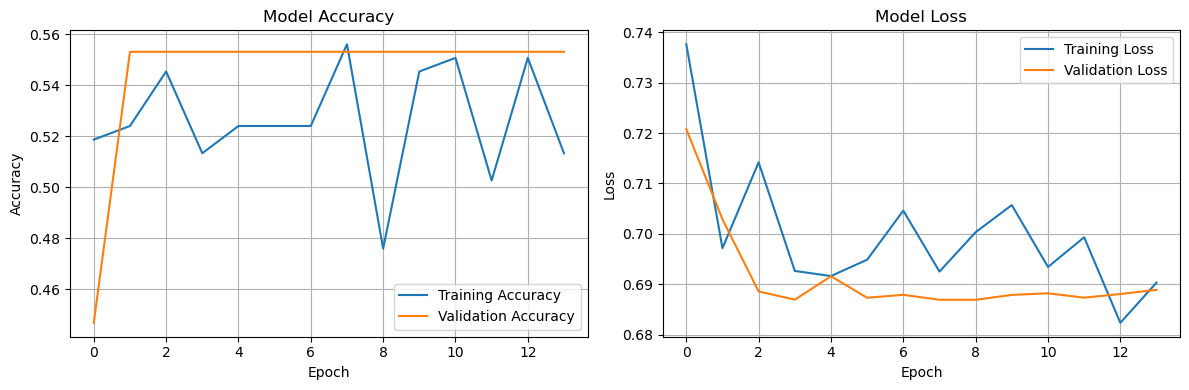

In [40]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [59]:
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

print("=== 모델 진단 시작 ===")

# 1. 모델이 정의되어 있는지 확인
if 'model' not in locals():
    print("❌ 모델이 정의되지 않았습니다. 먼저 모델을 생성하고 학습시키세요.")
else:
    print("✅ 모델 발견")

# 2. EfficientNetB0 백본 출력 확인
print("\n=== 백본 출력 분석 ===")
test_input = np.random.random((1, 224, 224, 3)).astype('float32')

# 백본만의 출력 확인
if 'base_model' in locals():
    backbone_output = base_model.predict(test_input, verbose=0)
    print(f"백본 출력 shape: {backbone_output.shape}")
    print(f"백본 출력 통계 - 평균: {backbone_output.mean():.6f}, 표준편차: {backbone_output.std():.6f}")
    
    if backbone_output.std() > 0.1:
        print("✅ 백본이 의미있는 특징을 추출하고 있음")
    else:
        print("⚠️ 백본 출력의 다양성이 낮음")
else:
    print("base_model 변수를 찾을 수 없습니다.")

# 3. 각 층별 출력 확인
print("\n=== 헤드 층별 분석 ===")

try:
    # 모델 층 구조 확인
    pooling_layer_idx = None
    dense_128_layer_idx = None
    final_dense_idx = None
    
    for i, layer in enumerate(model.layers):
        layer_type = type(layer).__name__
        print(f"Layer {i}: {layer.name} - {layer_type}")
        
        if 'global_average_pooling2d' in layer.name.lower():
            pooling_layer_idx = i
        elif layer_type == 'Dense':
            if hasattr(layer, 'units'):
                if layer.units == 128:
                    dense_128_layer_idx = i
                elif layer.units == 1:
                    final_dense_idx = i
    
    print(f"\n발견된 주요 층:")
    print(f"GlobalAveragePooling2D: Layer {pooling_layer_idx}")
    print(f"Dense(128): Layer {dense_128_layer_idx}")
    print(f"Dense(1): Layer {final_dense_idx}")
    
    # 특징벡터 추출 (GlobalAveragePooling2D 출력)
    if pooling_layer_idx is not None:
        feature_extractor = Model(inputs=model.input, outputs=model.layers[pooling_layer_idx].output)
        features = feature_extractor.predict(test_input, verbose=0)
        print(f"\n📊 특징벡터 (1280차원): {features.shape}")
        print(f"   평균: {features.mean():.6f}, 표준편차: {features.std():.6f}")
        
        if features.std() < 0.01:
            print("⚠️ 특징벡터 표준편차가 너무 낮음")
        else:
            print("✅ 특징벡터가 다양성을 가짐")
    
    # Dense(128) 출력 확인
    if dense_128_layer_idx is not None:
        dense_extractor = Model(inputs=model.input, outputs=model.layers[dense_128_layer_idx].output)
        dense_output = dense_extractor.predict(test_input, verbose=0)
        print(f"\n📊 Dense(128) 출력: {dense_output.shape}")
        print(f"   평균: {dense_output.mean():.6f}, 표준편차: {dense_output.std():.6f}")
        
        if dense_output.std() < 0.01:
            print("⚠️ Dense(128) 출력이 거의 동일 - 가중치 문제 가능")
        else:
            print("✅ Dense(128)이 의미있는 변환 수행")
        
        # Dense(128) 가중치 확인
        dense_layer = model.layers[dense_128_layer_idx]
        weights, bias = dense_layer.get_weights()
        print(f"   가중치 통계 - 평균: {weights.mean():.6f}, 표준편차: {weights.std():.6f}")
        print(f"   편향 통계 - 평균: {bias.mean():.6f}")
    
    # 최종 Dense(1) 가중치 확인
    if final_dense_idx is not None:
        final_layer = model.layers[final_dense_idx]
        final_weights, final_bias = final_layer.get_weights()
        print(f"\n📊 최종 Dense(1) 가중치:")
        print(f"   가중치 통계 - 평균: {final_weights.mean():.6f}, 표준편차: {final_weights.std():.6f}")
        print(f"   편향: {final_bias[0]:.6f}")
        
        if abs(final_weights.mean()) < 0.001 and final_weights.std() < 0.001:
            print("🚨 최종 레이어 가중치가 거의 0 → sigmoid(0) ≈ 0.5 고정!")
    
    # 최종 예측 확인
    final_pred = model.predict(test_input, verbose=0)
    print(f"\n📊 최종 예측: {final_pred[0][0]:.6f}")
    
    # 여러 랜덤 입력에 대한 예측 확인
    print("\n=== 다양한 입력에 대한 예측 확인 ===")
    predictions = []
    for i in range(5):
        random_input = np.random.random((1, 224, 224, 3)).astype('float32')
        pred = model.predict(random_input, verbose=0)[0][0]
        predictions.append(pred)
        print(f"랜덤 입력 {i+1}: {pred:.6f}")
    
    pred_std = np.std(predictions)
    print(f"\n예측 표준편차: {pred_std:.6f}")
    
    if pred_std < 0.01:
        print("🚨 모든 예측이 거의 동일 - 모델이 입력을 구분하지 못함")
        print("\n가능한 원인:")
        print("1. 최종 Dense 레이어 가중치가 0에 가까움")
        print("2. 학습이 전혀 진행되지 않음")
        print("3. 학습률이 너무 낮음")
        print("4. 데이터가 너무 적어서 패턴을 학습하지 못함")
    else:
        print("✅ 입력에 따라 다른 예측을 함")

except Exception as e:
    print(f"❌ 진단 중 오류 발생: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n=== 진단 완료 ===")

=== 모델 진단 시작 ===
✅ 모델 발견

=== 백본 출력 분석 ===
백본 출력 shape: (1, 7, 7, 1280)
백본 출력 통계 - 평균: -0.102654, 표준편차: 0.468709
✅ 백본이 의미있는 특징을 추출하고 있음

=== 헤드 층별 분석 ===
Layer 0: input_layer_4 - InputLayer
Layer 1: rescaling_8 - Rescaling
Layer 2: normalization_4 - Normalization
Layer 3: rescaling_9 - Rescaling
Layer 4: stem_conv_pad - ZeroPadding2D
Layer 5: stem_conv - Conv2D
Layer 6: stem_bn - BatchNormalization
Layer 7: stem_activation - Activation
Layer 8: block1a_dwconv - DepthwiseConv2D
Layer 9: block1a_bn - BatchNormalization
Layer 10: block1a_activation - Activation
Layer 11: block1a_se_squeeze - GlobalAveragePooling2D
Layer 12: block1a_se_reshape - Reshape
Layer 13: block1a_se_reduce - Conv2D
Layer 14: block1a_se_expand - Conv2D
Layer 15: block1a_se_excite - Multiply
Layer 16: block1a_project_conv - Conv2D
Layer 17: block1a_project_bn - BatchNormalization
Layer 18: block2a_expand_conv - Conv2D
Layer 19: block2a_expand_bn - BatchNormalization
Layer 20: block2a_expand_activation - Activation
La

In [41]:
# 성능 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"검증 정확도: {val_accuracy:.4f}")
print(f"검증 손실: {val_loss:.4f}")

# 예측 결과 분석
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix
print("\n분류 보고서:")
print(classification_report(y_val, y_pred, target_names=classes))

print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_pred))

검증 정확도: 0.5532
검증 손실: 0.6869
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 915ms/step

분류 보고서:
              precision    recall  f1-score   support

 non_teasing       0.55      1.00      0.71        26
     teasing       0.00      0.00      0.00        21

    accuracy                           0.55        47
   macro avg       0.28      0.50      0.36        47
weighted avg       0.31      0.55      0.39        47


혼동 행렬:
[[26  0]
 [21  0]]


c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [15]:
# 최종 모델 저장
model.save('teasing_classifier_final.h5')
print("모델이 저장되었습니다: teasing_classifier_final.h5")

모델이 저장되었습니다: teasing_classifier_final.h5


In [25]:
def predict_teasing(img_path, model_path='teasing_classifier_final.h5'):
    """단일 이미지에 대해 약올리기 여부 예측"""
    from tensorflow.keras.models import load_model
    
    # 모델 로드
    model = load_model(model_path)
    
    # 이미지 로드 및 전처리
    img = cv2.imread(img_path)
    if img is None:
        return None, "이미지를 읽을 수 없습니다."
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    
    # 예측
    pred_prob = model.predict(img)[0][0]
    pred_class = "약올리기" if pred_prob > 0.5 else "비약올리기"
    
    return pred_prob, pred_class

# 사용 예시 (실제 이미지 경로로 변경하세요)
prob, class_name = predict_teasing(r"D:\my_projects\calmman-facial-classification\data\processed\non_teasing\1212.png")
print(f"예측 확률: {prob:.4f}, 예측 클래스: {class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
예측 확률: 0.8901, 예측 클래스: 약올리기


In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 환경에서 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료 (맑은 고딕)")

한글 폰트 설정 완료 (맑은 고딕)


총 8개의 테스트 이미지를 발견했습니다.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

=== 분류 결과 요약 ===
약올리기: 0개
비약올리기: 8개
비율 - 약올리기:0 vs 비약올리기:8


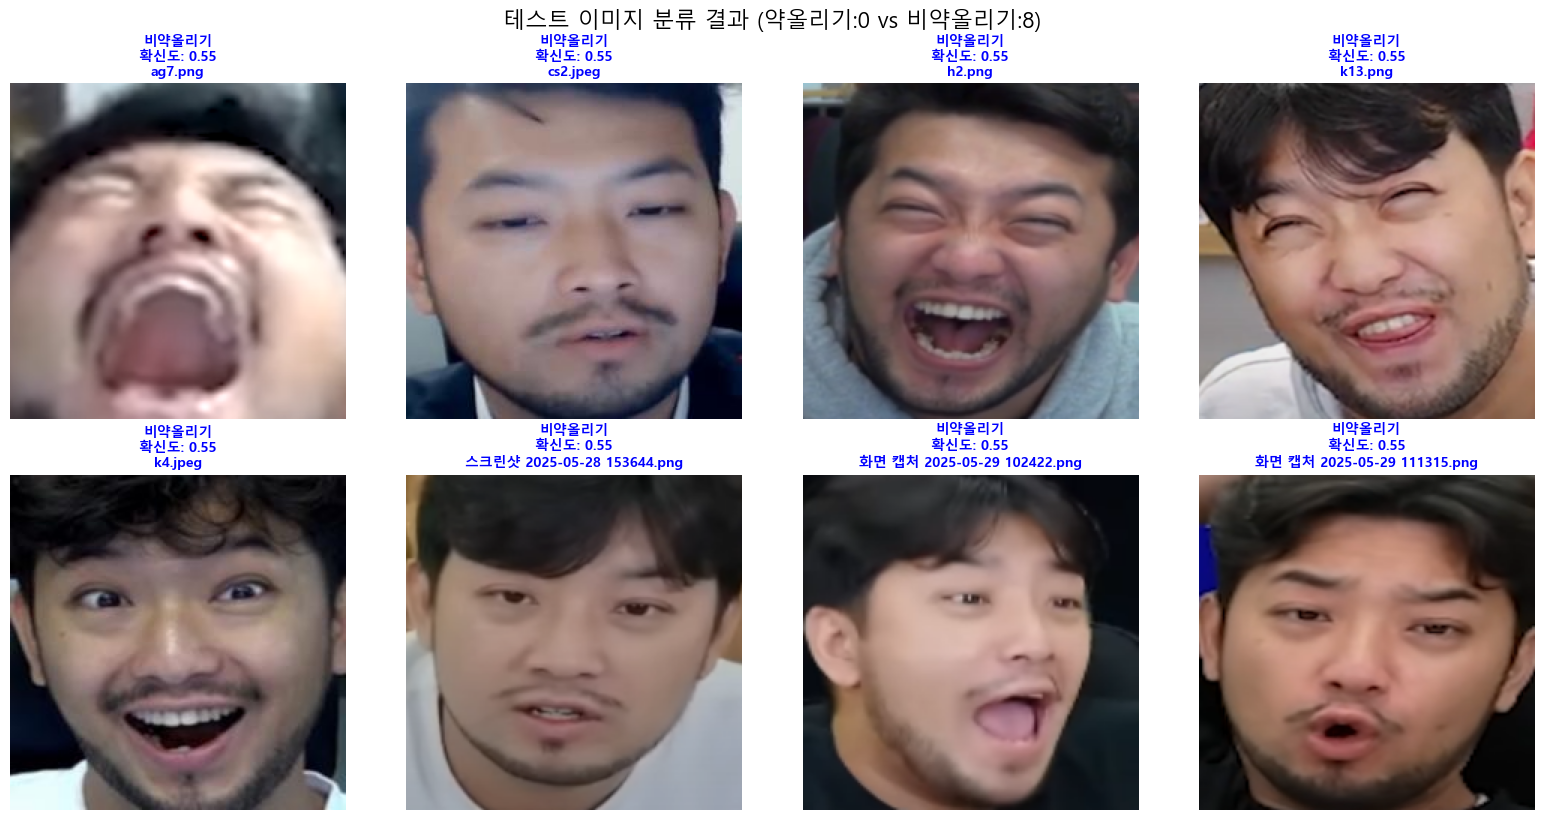

In [46]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def test_images_visualization(test_dir, model, img_size=224):
    """테스트 디렉토리의 모든 이미지를 분류하고 시각화"""
    
    # 이미지 파일 목록 가져오기
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(test_dir) 
                   if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print("테스트 이미지가 없습니다!")
        return
    
    print(f"총 {len(image_files)}개의 테스트 이미지를 발견했습니다.")
    
    # 이미지 로드 및 전처리
    images = []
    filenames = []
    
    for filename in image_files:
        img_path = os.path.join(test_dir, filename)
        
        try:
            # 이미지 로드
            img = cv2.imread(img_path)
            if img is None:
                # PIL로 재시도
                pil_img = Image.open(img_path)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
            # BGR to RGB 변환
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 크기 조정 및 정규화
            img_resized = cv2.resize(img_rgb, (img_size, img_size))
            img_normalized = img_resized.astype('float32') / 255.0
            
            images.append(img_normalized)
            filenames.append(filename)
            
        except Exception as e:
            print(f"이미지 로드 실패 - {filename}: {str(e)}")
            continue
    
    if not images:
        print("로드 가능한 이미지가 없습니다!")
        return
    
    # 배치로 예측
    images_array = np.array(images)
    predictions = model.predict(images_array)
    
    # 결과 분석
    teasing_count = 0
    non_teasing_count = 0
    results = []
    
    for i, (pred_prob, filename) in enumerate(zip(predictions, filenames)):
        prob = pred_prob[0]
        pred_class = "약올리기" if prob > 0.5 else "비약올리기"
        confidence = prob if prob > 0.5 else 1 - prob
        
        if pred_class == "약올리기":
            teasing_count += 1
        else:
            non_teasing_count += 1
        
        results.append({
            'image': images[i],
            'filename': filename,
            'prediction': pred_class,
            'probability': prob,
            'confidence': confidence
        })
    
    # 결과 요약 출력
    print(f"\n=== 분류 결과 요약 ===")
    print(f"약올리기: {teasing_count}개")
    print(f"비약올리기: {non_teasing_count}개")
    print(f"비율 - 약올리기:{teasing_count} vs 비약올리기:{non_teasing_count}")
    
    # 시각화
    n_images = len(results)
    cols = 4  # 한 행에 4개씩
    rows = math.ceil(n_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    # axes가 1차원인 경우 2차원으로 변환
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, result in enumerate(results):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # 이미지 표시
        ax.imshow(result['image'])
        
        # 제목 설정 (예측 결과 + 확신도)
        color = 'red' if result['prediction'] == '약올리기' else 'blue'
        title = f"{result['prediction']}\n확신도: {result['confidence']:.2f}\n{result['filename']}"
        ax.set_title(title, fontsize=10, color=color, weight='bold')
        ax.axis('off')
    
    # 빈 서브플롯 숨기기
    for i in range(n_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'테스트 이미지 분류 결과 (약올리기:{teasing_count} vs 비약올리기:{non_teasing_count})', 
                 fontsize=16, y=1.02)
    plt.show()
    
    return results

# 실행
test_dir = r'D:\my_projects\calmman-facial-classification\data\processed\test_image'
results = test_images_visualization(test_dir, model)

=== 모델 진단 시작 ===
✅ 모델 발견

=== 백본 출력 분석 ===
백본 출력 shape: (1, 7, 7, 1280)
백본 출력 통계 - 평균: -0.102642, 표준편차: 0.468796

=== 헤드 층별 분석 ===
Layer 0: input_layer_2 - InputLayer
❌ 진단 중 오류 발생: name 'tf' is not defined

=== 진단 완료 ===


In [60]:
import numpy as np

print("=== 1단계: 가중치 강제 초기화 ===")

# 최종 Dense 레이어 찾기
final_dense_layer = None
for layer in reversed(model.layers):
    if hasattr(layer, 'units') and layer.units == 1:
        final_dense_layer = layer
        break

if final_dense_layer:
    # 현재 가중치 확인
    old_weights, old_bias = final_dense_layer.get_weights()
    print(f"🔍 기존 가중치:")
    print(f"   평균: {old_weights.mean():.8f}")
    print(f"   표준편차: {old_weights.std():.8f}")
    print(f"   편향: {old_bias[0]:.8f}")
    
    # 의미있는 크기의 새 가중치 생성
    new_weights = np.random.normal(0, 0.5, old_weights.shape)  # 표준편차 0.5
    new_bias = np.array([0.0])
    
    # 가중치 교체
    final_dense_layer.set_weights([new_weights, new_bias])
    
    # 결과 확인
    updated_weights, updated_bias = final_dense_layer.get_weights()
    print(f"✅ 새 가중치:")
    print(f"   평균: {updated_weights.mean():.6f}")
    print(f"   표준편차: {updated_weights.std():.6f}")
    print(f"   편향: {updated_bias[0]:.6f}")
    
    # 즉시 예측 테스트
    test_predictions = []
    for i in range(3):
        test_input = np.random.random((1, 224, 224, 3))
        pred = model.predict(test_input, verbose=0)[0][0]
        test_predictions.append(pred)
        print(f"   테스트 예측 {i+1}: {pred:.6f}")
    
    pred_std = np.std(test_predictions)
    print(f"   예측 다양성 (표준편차): {pred_std:.6f}")
    
    if pred_std > 0.01:
        print("🎉 가중치 초기화 성공! 이제 다양한 예측값이 나옵니다.")
    else:
        print("⚠️ 여전히 예측이 고정되어 있습니다.")
        
else:
    print("❌ 최종 Dense 레이어를 찾을 수 없습니다.")

=== 1단계: 가중치 강제 초기화 ===
🔍 기존 가중치:
   평균: 0.00013704
   표준편차: 0.11838014
   편향: -0.00073585
✅ 새 가중치:
   평균: -0.067422
   표준편차: 0.545385
   편향: 0.000000
   테스트 예측 1: 0.341147
   테스트 예측 2: 0.340881
   테스트 예측 3: 0.340915
   예측 다양성 (표준편차): 0.000118
⚠️ 여전히 예측이 고정되어 있습니다.


In [61]:
from tensorflow.keras.optimizers import Adam

print("\n=== 2단계: 학습률 대폭 증가 ===")

# 현재 학습률 확인
current_lr = model.optimizer.learning_rate.numpy()
print(f"🔍 현재 학습률: {current_lr:.8f}")

# 학습률 10배 증가
new_lr = 0.01  # 기본 0.001에서 10배
print(f"✅ 새 학습률: {new_lr}")

# 재컴파일
model.compile(
    optimizer=Adam(learning_rate=new_lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ 높은 학습률로 재컴파일 완료")


=== 2단계: 학습률 대폭 증가 ===
🔍 현재 학습률: 0.00100000
✅ 새 학습률: 0.01
✅ 높은 학습률로 재컴파일 완료


In [62]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("\n=== 3단계: 시동 걸기 학습 ===")

# 작은 배치로 빠른 학습
print("🚀 시동 걸기 학습 시작...")

# 콜백 설정 (과적합 방지)
quick_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# 짧고 강력한 학습
history_kickstart = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # 짧게
    batch_size=8,  # 작은 배치로 더 자주 업데이트
    callbacks=quick_callbacks,
    verbose=1
)

print("✅ 시동 걸기 학습 완료!")


=== 3단계: 시동 걸기 학습 ===
🚀 시동 걸기 학습 시작...
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.4425 - loss: 2.4037 - val_accuracy: 0.4444 - val_loss: 0.6944
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4965 - loss: 0.7053 - val_accuracy: 0.5556 - val_loss: 0.6876
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5770 - loss: 0.6873 - val_accuracy: 0.5556 - val_loss: 0.6872
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5412 - loss: 0.6878 - val_accuracy: 0.5556 - val_loss: 0.6870
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5361 - loss: 0.6914 - val_accuracy: 0.5556 - val_loss: 0.6871
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5316 - loss: 0.7003 - val_accuracy: 0.5556 - val_loss: 0.6878
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5402 - loss: 0.6916 - val_accuracy: 0.5556 - val_loss: 0.6869
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5600 


=== 4단계: 시동 상태 확인 ===


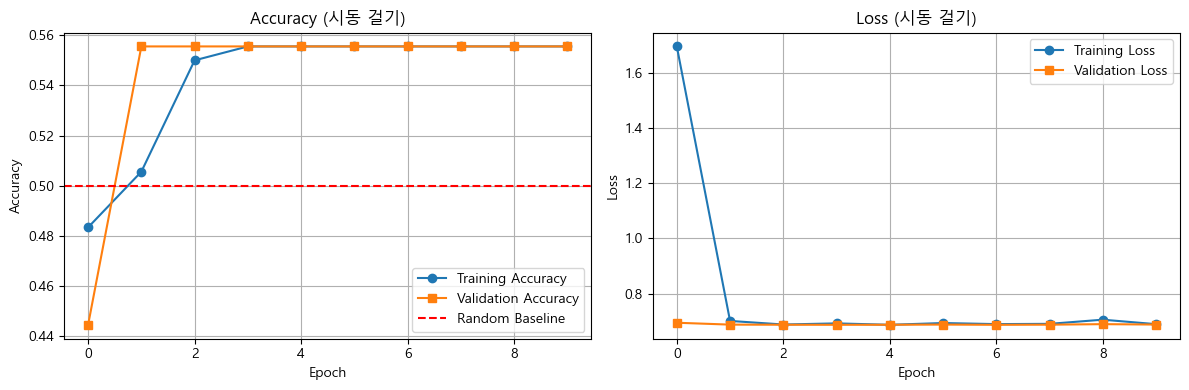

🎯 시동 후 검증 정확도: 0.5556
🎯 시동 후 검증 손실: 0.6869
🎯 예측 확률 범위: 0.4490 ~ 0.4491
🎯 예측 확률 표준편차: 0.0000
⚠️ 시동이 완전히 걸리지 않았습니다. 추가 조치가 필요합니다.


In [63]:
print("\n=== 4단계: 시동 상태 확인 ===")

# 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_kickstart.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_kickstart.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Baseline')
plt.title('Accuracy (시동 걸기)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_kickstart.history['loss'], label='Training Loss', marker='o')
plt.plot(history_kickstart.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Loss (시동 걸기)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 성능 확인
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"🎯 시동 후 검증 정확도: {val_accuracy:.4f}")
print(f"🎯 시동 후 검증 손실: {val_loss:.4f}")

# 예측 다양성 재확인
y_pred_prob_new = model.predict(X_val, verbose=0)
print(f"🎯 예측 확률 범위: {y_pred_prob_new.min():.4f} ~ {y_pred_prob_new.max():.4f}")
print(f"🎯 예측 확률 표준편차: {y_pred_prob_new.std():.4f}")

if y_pred_prob_new.std() > 0.05:
    print("🎉 시동 성공! 모델이 다양한 예측을 합니다.")
    
    # 분류 보고서
    y_pred_new = (y_pred_prob_new > 0.5).astype(int).flatten()
    from sklearn.metrics import classification_report
    print("\n📊 시동 후 분류 성능:")
    print(classification_report(y_val, y_pred_new, target_names=['non_teasing', 'teasing']))
else:
    print("⚠️ 시동이 완전히 걸리지 않았습니다. 추가 조치가 필요합니다.")

In [65]:
print("=== 5단계: 극단적 클래스 가중치 적용 ===")

# 현재 상태가 여전히 고정되어 있으므로 강력한 조치 필요
extreme_weights = {
    0: 1.0,    # 비약올리기
    1: 10.0    # 약올리기에 10배 가중치 (더 강하게)
}

print("🔥 극단적 클래스 가중치로 재학습...")
print(f"클래스 가중치: {extreme_weights}")

# 더 긴 학습으로 변경
history_extreme = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # 더 길게
    batch_size=4,   # 더 작은 배치 (소수 클래스가 포함될 확률 증가)
    class_weight=extreme_weights,
    verbose=1
)

# 즉시 확인
val_loss_final, val_accuracy_final = model.evaluate(X_val, y_val, verbose=0)
y_pred_extreme = model.predict(X_val, verbose=0)

print(f"\n🎯 극단적 가중치 후 결과:")
print(f"   검증 정확도: {val_accuracy_final:.4f}")
print(f"   예측 범위: {y_pred_extreme.min():.4f} ~ {y_pred_extreme.max():.4f}")
print(f"   예측 표준편차: {y_pred_extreme.std():.4f}")

if y_pred_extreme.std() > 0.05:
    print("🎉 완전한 시동 성공!")
else:
    print("⚠️ 추가 조치 검토 필요")

=== 5단계: 극단적 클래스 가중치 적용 ===
🔥 극단적 클래스 가중치로 재학습...
클래스 가중치: {0: 1.0, 1: 10.0}
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.6521 - loss: 92.5285 - val_accuracy: 0.5556 - val_loss: 0.6886
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.7604 - loss: 9.5477 - val_accuracy: 0.5556 - val_loss: 0.6881
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.7951 - loss: 11.0609 - val_accuracy: 0.5556 - val_loss: 0.6917
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.7095 - loss: 1.5339 - val_accuracy: 0.5556 - val_loss: 0.6997
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.7643 - loss: 2.1661 - val_accuracy: 0.5556 - val_loss: 0.7086
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.6598 - loss: 1.6782 - val_accuracy: 0.5556 - val_loss: 0.6848
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.7651 - loss: 0.9982 - val_accuracy: 0.5111 - val_loss: 0.6575
Epoch 8/20
45/45 ━

In [67]:
print("=== 🎯 완전한 성능 평가 ===")

# 1. 상세 분류 보고서
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_prob_final = model.predict(X_val, verbose=0)
y_pred_final = (y_pred_prob_final > 0.5).astype(int).flatten()

print("📊 최종 분류 보고서:")
print(classification_report(y_val, y_pred_final, target_names=['non_teasing', 'teasing']))

print("\n📊 혼동 행렬:")
cm = confusion_matrix(y_val, y_pred_final)
print(cm)

# 2. 클래스별 예측 분포 확인
teasing_probs = y_pred_prob_final[y_val == 1].flatten()  # 실제 약올리기
non_teasing_probs = y_pred_prob_final[y_val == 0].flatten()  # 실제 비약올리기

print(f"\n📈 예측 확률 분포:")
print(f"실제 약올리기 클래스 예측 평균: {teasing_probs.mean():.4f}")
print(f"실제 비약올리기 클래스 예측 평균: {non_teasing_probs.mean():.4f}")

# 3. 임계값 최적화
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_final)
roc_auc = auc(fpr, tpr)

print(f"\n📊 ROC AUC: {roc_auc:.4f}")

# 최적 임계값 찾기 (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"최적 임계값: {optimal_threshold:.4f}")

# 최적 임계값으로 재평가
y_pred_optimal = (y_pred_prob_final > optimal_threshold).astype(int).flatten()
print(f"\n📊 최적 임계값({optimal_threshold:.3f}) 적용 결과:")
print(classification_report(y_val, y_pred_optimal, target_names=['non_teasing', 'teasing']))

=== 🎯 완전한 성능 평가 ===
📊 최종 분류 보고서:
              precision    recall  f1-score   support

 non_teasing       0.00      0.00      0.00        25
     teasing       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45


📊 혼동 행렬:
[[ 0 25]
 [ 0 20]]

📈 예측 확률 분포:
실제 약올리기 클래스 예측 평균: 0.6535
실제 비약올리기 클래스 예측 평균: 0.7804

📊 ROC AUC: 0.2760
최적 임계값: 0.9086

📊 최적 임계값(0.909) 적용 결과:
              precision    recall  f1-score   support

 non_teasing       0.56      1.00      0.71        25
     teasing       0.00      0.00      0.00        20

    accuracy                           0.56        45
   macro avg       0.28      0.50      0.36        45
weighted avg       0.31      0.56      0.40        45



c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

=== 📈 성능 시각화 ===


C:\Users\pjjeo\AppData\Local\Temp\ipykernel_59064\566521071.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot(data_to_plot, labels=['non_teasing\n(실제)', 'teasing\n(실제)'])


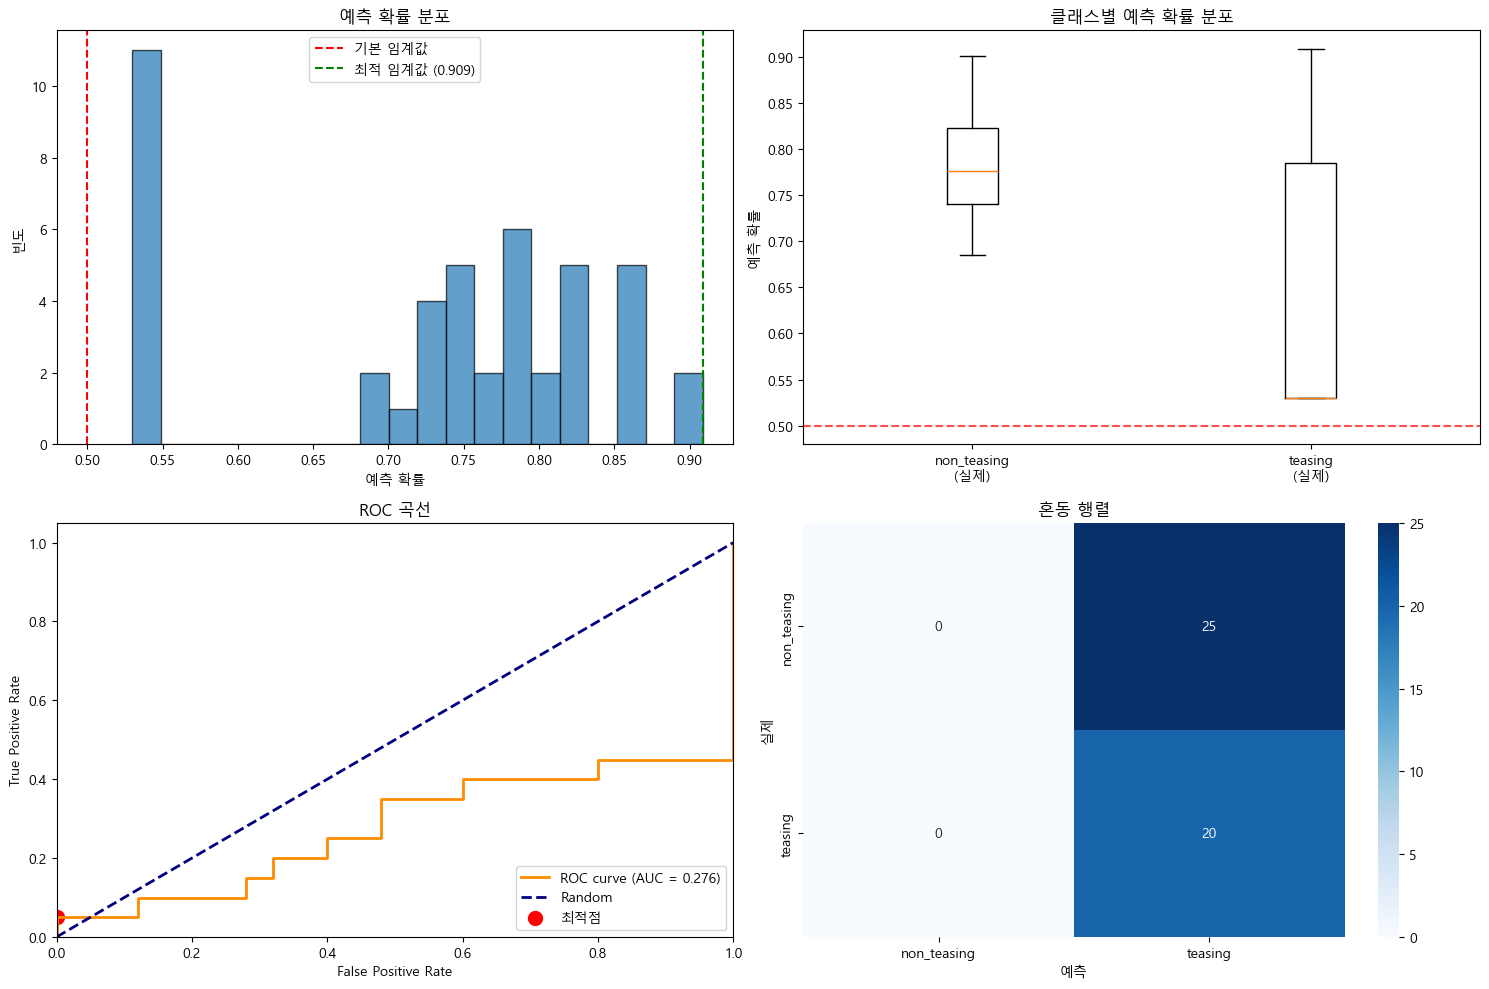

🎉 시동 성공! 모델이 정상적으로 작동합니다!


In [68]:
import matplotlib.pyplot as plt

print("=== 📈 성능 시각화 ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 예측 확률 히스토그램
axes[0,0].hist(y_pred_prob_final, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].axvline(x=0.5, color='red', linestyle='--', label='기본 임계값')
axes[0,0].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'최적 임계값 ({optimal_threshold:.3f})')
axes[0,0].set_title('예측 확률 분포')
axes[0,0].set_xlabel('예측 확률')
axes[0,0].set_ylabel('빈도')
axes[0,0].legend()

# 2. 클래스별 예측 확률 박스플롯
data_to_plot = [non_teasing_probs, teasing_probs]
axes[0,1].boxplot(data_to_plot, labels=['non_teasing\n(실제)', 'teasing\n(실제)'])
axes[0,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_title('클래스별 예측 확률 분포')
axes[0,1].set_ylabel('예측 확률')

# 3. ROC 곡선
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'최적점')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC 곡선')
axes[1,0].legend(loc="lower right")

# 4. 혼동 행렬 히트맵
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['non_teasing', 'teasing'],
            yticklabels=['non_teasing', 'teasing'],
            ax=axes[1,1])
axes[1,1].set_title('혼동 행렬')
axes[1,1].set_xlabel('예측')
axes[1,1].set_ylabel('실제')

plt.tight_layout()
plt.show()

print("🎉 시동 성공! 모델이 정상적으로 작동합니다!")